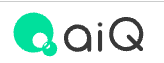

[disclaimer](../disclaimer.txt/)

# Data Handler

データベースからデータを取得し、保持するためのコンポネントです。<br>
保持しているデータを加工して新しい feature を作成したり、グラフに可視化させる機能を持ちます。

## 0. 事前準備

In [1]:
# サンプル用のライブラリをインポート
import os
import pandas as pd

### データハンドラー(DAL)のインポート

In [2]:
from aiq_strategy_robot.data.data_accessor import DAL
sdh = DAL()

### ヘルパー関数のインポート

データソース（**factset**, **finnhub**..etc）からデータロードを行う際に、ハンドラーのヘルパー関数を使用します.<br>
以下に当サンプルで利用するヘルパー関数をインポートします.

In [3]:
from aiq_strategy_robot.data.FINNHUB import (
    load_finnhub_symbol_lookup,
    load_finnhub_fundamental, 
    load_finnhub_equity_data, 
)

from aiq_strategy_robot.data.ALTERNATIVE import (
    load_alternative_aiq_pos_csmr_goods_universe, 
    load_alternative_aiq_pos_csmr_goods_data
)

## 1. symbol_lookup

一般的な Bloomberg で使う Ticker コードからそれぞれのデータベンダーの symbol コードを調べるために使う end pointです

In [4]:
# 例： finnhub loader の symbol_lookup
tickers = ['4661 JP', '9983 JP', 'AAPL US']

df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=['4661 JP', '9983 JP', 'AAPL US']).retrieve()
display(df_symbols_finnhub.head())

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,ticker
0,JPY,ORIENTAL LAND CO LTD,4661.T,BBG000HPZ220,None,XJPX,BBG001S9BPK7,4661.T,,Common Stock,4661 JP
1,JPY,FAST RETAILING CO LTD,9983.T,BBG000CLY9R3,None,XJPX,BBG001S82FV9,9983.T,,Common Stock,9983 JP
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL.T,NaN,NaN,AAPL US


### オルタナティブデータとFinnhubの両方に存在するSymbolを取得

#### オルタナティブデータ`aiQ POS csmr goods`のuniverseを取得

In [5]:
sdh = DAL()
aiq_pos_universe = load_alternative_aiq_pos_csmr_goods_universe(sdh).retrieve()
aiq_pos_universe.head()

,FIGI,TICKER
0,BBG000DHKLR9,7297
1,BBG000BJ8BL9,2294
2,BBG000BQL4W2,9069
3,BBG000BCTFS5,2009
4,BBG000CG35V1,2915


#### Finnhubのシンボルを取得
`aiQ POS csmr goods`のuniverseのTickerをキーに、Finnhubのシンボルを取得

In [6]:
# シンボルの取得
df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=(aiq_pos_universe.TICKER + ' JP').to_list() ).retrieve()

サンプルとして6件抽出

In [7]:
num = 6
df_symbols_finnhub = df_symbols_finnhub.dropna(subset='currency').sample(num)
display(df_symbols_finnhub)

tickers = df_symbols_finnhub.ticker.to_list()
alt_tickers = df_symbols_finnhub.ticker.str.split(' ').str[0].to_list()
finnhub_symbols = df_symbols_finnhub.symbol.to_list()

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,ticker
172,JPY,DAIICHI SANKYO CO LTD,4568.T,BBG000BWPMB8,None,XJPX,BBG001SJB4R5,4568.T,,Common Stock,4568 JP
155,JPY,WAKAMOTO PHARM CO LTD,4512.T,BBG000BCWM24,None,XJPX,BBG001S6CDX5,4512.T,,Common Stock,4512 JP
191,JPY,KONISHI CO LTD,4956.T,BBG000DK33V6,None,XJPX,BBG001S88MH4,4956.T,,Common Stock,4956 JP
141,JPY,ISHIHARA SANGYO KAISHA LTD,4028.T,BBG000BG10X3,None,XJPX,BBG001S6B8D9,4028.T,,Common Stock,4028 JP
38,JPY,MORINAGA MILK INDUSTRY CO,2264.T,BBG000BHDYG3,None,XJPX,BBG001S6C2X9,2264.T,,Common Stock,2264 JP
183,JPY,MANDOM CORP,4917.T,BBG000BKB4J1,None,XJPX,BBG001S6J3G9,4917.T,,Common Stock,4917 JP


## 2. 株価の取得

In [8]:
sdh = DAL()

# 日次データの取得
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='D',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

4917.T: loading...: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


close        high         low        open    volume  \
ticker  datetime                                                               
4568 JP 2010-01-04  649.666033  654.999367  649.332667  649.999367   3575703   
        2010-01-05  653.332667  656.666000  651.999367  656.666000   4698003   
        2010-01-06  659.999333  664.999333  654.666000  656.666000   6320706   
        2010-01-07  659.999333  663.999333  658.332667  663.332667   5728503   
        2010-01-08  651.666033  663.332667  646.999367  663.332667  10106709   

                    dividends  split_ratio  
ticker  datetime                            
4568 JP 2010-01-04        0.0     0.333333  
        2010-01-05        0.0     0.333333  
        2010-01-06        0.0     0.333333  
        2010-01-07        0.0     0.333333  
        2010-01-08        0.0     0.333333

In [9]:
# 週次データを取得
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='W',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

4917.T: loading...: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


close        high         low        open  \
ticker  datetime                                                     
4568 JP 2010-01-04  651.666033  664.999333  646.999367  649.999367   
        2010-01-12  660.999333  666.666000  654.999367  659.999333   
        2010-01-18  652.332667  665.666000  645.999367  647.666033   
        2010-01-25  627.332700  658.332667  624.999367  656.666000   
        2010-02-01  603.666067  636.666033  595.332733  623.332700   

                        volume  dividends  split_ratio  
ticker  datetime                                        
4568 JP 2010-01-04  30429624.0        0.0     0.333333  
        2010-01-12  27508521.0        0.0     0.333333  
        2010-01-18  36666027.0        0.0     0.333333  
        2010-01-25  39484530.0        0.0     0.333333  
        2010-02-01  50739042.0        0.0     0.333333

### Appendix

#### ロードデータの確認

取得データはハンドラーに登録され、取得データ毎に`data_id`が付与されます.

In [10]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,None,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,NaN,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00


In [11]:
# Aliasを設定
sdh.set_alias({1: 'finhub_price_D', 2: 'finhub_price_W'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00


#### ロードデータの取得
#### 1. ロード直後のハンドラーから`retrieve`メソッドで取得
`retrieve`メソッドでは直前にロードしたデータのみ取得できます.

In [12]:
sdh.retrieve().tail()

close    high     low    open     volume  dividends  \
ticker  datetime                                                           
4917 JP 2023-11-27  1280.0  1292.0  1267.0  1273.0   704400.0        0.0   
        2023-12-04  1278.0  1297.0  1270.0  1279.0   811700.0        0.0   
        2023-12-11  1262.0  1284.0  1259.0  1282.0  1026500.0        0.0   
        2023-12-18  1270.0  1273.0  1245.0  1254.0   789600.0        0.0   
        2023-12-25  1275.0  1279.0  1260.0  1274.0   623200.0        0.0   

                    split_ratio  
ticker  datetime                 
4917 JP 2023-11-27          1.0  
        2023-12-04          1.0  
        2023-12-11          1.0  
        2023-12-18          1.0  
        2023-12-25          1.0

#### 2. `data_id`を指定して`get_raw_data`メソッドで取得
`data_id`により登録済みのデータを取得できます.

In [13]:
sdh.get_raw_data(2).tail()

close    high     low    open    volume  dividends  \
ticker  datetime                                                          
4956 JP 2023-12-04  1212.0  1302.0  1206.5  1275.5  454200.0        0.0   
        2023-12-11  1271.0  1279.0  1206.0  1220.0  505000.0        0.0   
        2023-12-18  1322.5  1322.5  1223.5  1258.5  329600.0        0.0   
        2023-12-25  1355.0  1357.0  1313.5  1325.0  299600.0        0.0   
        2023-12-28     NaN     NaN     NaN     NaN       NaN        NaN   

                    split_ratio  
ticker  datetime                 
4956 JP 2023-12-04          0.5  
        2023-12-11          0.5  
        2023-12-18          0.5  
        2023-12-25          0.5  
        2023-12-28          0.5

## 3. 財務データの取得

In [14]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='ic',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

4917.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


costOfGoodsSold  dilutedAverageSharesOutstanding  \
ticker  datetime                                                       
4568 JP 2014-06-30          64586.0                            704.0   
        2014-09-30          66204.0                            705.0   
        2014-12-31          90136.0                            705.0   
        2015-03-31          31466.0                            704.0   
        2015-06-30          73961.0                            703.0   

                    dilutedEPS     ebit  grossIncome  interestIncomeExpense  \
ticker  datetime                                                              
4568 JP 2014-06-30       28.38  32790.0     149120.0                  -94.0   
        2014-09-30       43.03  27447.0     149680.0                 2020.0   
        2014-12-31       73.62  39739.0     174671.0                 5565.0   
        2015-03-31      312.33 -35854.0      49738.0                 8866.0   
        2015-06-30       49.68  49126.0     164456.0                -3931.0   

                    minorityInterest  netIncome  netIncomeAfterTaxes  \
ticker  datetime                                                       
4568 JP 2014-06-30            1440.0    19986.0              20893.0   
        2014-09-30           -1423.0    30339.0              14337.0   
        2014-12-31            2814.0    51907.0              31281.0   
        2015-03-31             364.0   219886.0             -55836.0   
        2015-06-30             842.0    34932.0              34090.0   

                    otherOperatingExpensesTotal  pretaxIncome  \
ticker  datetime                                                
4568 JP 2014-06-30                          2.0       32695.0   
        2014-09-30                          2.0       29467.0   
        2014-12-31                          2.0       45304.0   
        2015-03-31                          NaN      -26988.0   
        2015-06-30                          1.0       45194.0   

                    provisionforIncomeTaxes  researchDevelopment   revenue  \
ticker  datetime                                                             
4568 JP 2014-06-30                  11802.0              41410.0  213706.0   
        2014-09-30                  15130.0              43482.0  215884.0   
        2014-12-31                  14023.0              50816.0  264807.0   
        2015-03-31                  28848.0              48490.0   81204.0   
        2015-06-30                  11104.0              43693.0  238417.0   

                    sgaExpense  totalOperatingExpense  \
ticker  datetime                                        
4568 JP 2014-06-30     74918.0               116330.0   
        2014-09-30     78749.0               122233.0   
        2014-12-31     84114.0               134932.0   
        2015-03-31     37102.0                85592.0   
        2015-06-30     71636.0               115330.0   

                    totalOtherIncomeExpenseNet  gainLossOnDispositionOfAssets  \
ticker  datetime                                                                
4568 JP 2014-06-30                        -1.0                            NaN   
        2014-09-30                         1.0                            NaN   
        2014-12-31                         1.0                            NaN   
        2015-03-31                         NaN                            NaN   
        2015-06-30                        -1.0                            NaN   

                    nonRecurringItems  depreciationAmortization  
ticker  datetime                                                 
4568 JP 2014-06-30                NaN                       NaN  
        2014-09-30                NaN                       NaN  
        2014-12-31                NaN                       NaN  
        2015-03-31                NaN                       NaN  
        2015-06-30                NaN                       NaN

In [15]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='bs',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

4917.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


accountsPayable  accountsReceivables  \
ticker  datetime                                           
4568 JP 2014-06-30         214530.0             254732.0   
        2014-09-30         229491.0             271103.0   
        2014-12-31         266656.0             327067.0   
        2015-03-31         235546.0             241547.0   
        2015-06-30         219116.0             246381.0   

                    additionalPaidInCapital  cashEquivalents  \
ticker  datetime                                               
4568 JP 2014-06-30                 105267.0         165683.0   
        2014-09-30                 105267.0         180274.0   
        2014-12-31                 105267.0         227036.0   
        2015-03-31                 105267.0         189372.0   
        2015-06-30                 104114.0         238412.0   

                    cashShortTermInvestments  commonStock  currentAssets  \
ticker  datetime                                                           
4568 JP 2014-06-30                  421722.0      50000.0       894856.0   
        2014-09-30                  440956.0      50000.0       931591.0   
        2014-12-31                  414805.0      50000.0       952870.0   
        2015-03-31                  375829.0      50000.0       785334.0   
        2015-06-30                  707101.0      50000.0      1129805.0   

                    currentLiabilities  currentPortionLongTermDebt  \
ticker  datetime                                                     
4568 JP 2014-06-30            368845.0                     97003.0   
        2014-09-30            397158.0                    102897.0   
        2014-12-31            460392.0                    124655.0   
        2015-03-31            297496.0                     20000.0   
        2015-06-30            275567.0                     20000.0   

                    deferredIncomeTax  ...  totalDebt  totalEquity  \
ticker  datetime                       ...                           
4568 JP 2014-06-30            42695.0  ...   358715.0     975764.0   
        2014-09-30            44714.0  ...   358968.0    1032735.0   
        2014-12-31            60653.0  ...   349279.0    1106897.0   
        2015-03-31            88357.0  ...   221000.0    1304057.0   
        2015-06-30            77911.0  ...   221000.0    1277846.0   

                    totalLiabilities  totalReceivables  treasuryStock  \
ticker  datetime                                                        
4568 JP 2014-06-30          781013.0          254732.0       -14403.0   
        2014-09-30          805334.0          271103.0       -14334.0   
        2014-12-31          857500.0          327067.0       -14223.0   
        2015-03-31          678229.0          241547.0       -14198.0   
        2015-06-30          649042.0          246381.0       -38279.0   

                    shortTermDebt  accruedLiability  accumulatedDepreciation  \
ticker  datetime                                                               
4568 JP 2014-06-30            0.0               NaN                      NaN   
        2014-09-30            0.0               NaN                      NaN   
        2014-12-31            0.0               NaN                      NaN   
        2015-03-31            0.0               NaN                      NaN   
        2015-06-30            0.0               NaN                      NaN   

                    unrealizedProfitLossSecurity  noteReceivableLongTerm  
ticker  datetime                                                          
4568 JP 2014-06-30                           NaN                     NaN  
        2014-09-30                           NaN                     NaN  
        2014-12-31                           NaN                     NaN  
        2015-03-31                           NaN                     NaN  
        2015-06-30                           NaN                     NaN  

[5 rows x 41 columns]

In [16]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,None,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,NaN,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00


In [17]:
sdh.set_alias({ 3: 'finhub_ic', 4: 'finhub_bs'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00


## 4. オルタナティブデータ(aiQ POS csmr goods)の取得

In [18]:
_sdh = DAL()

# generation=1
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=1,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,2264,BBG000BHDXG5,2008-03-16,pos_sales,0,56.566369,1,2008-03-21 08:00:00
1,2264,BBG000BHDXG5,2008-03-16,share,0,0.158083,1,2008-03-21 08:00:00
2,2264,BBG000BHDXG5,2008-03-16,unit_price,0,1.073670,1,2008-03-21 08:00:00
3,2264,BBG000BHDXG5,2008-03-23,pos_sales,0,54.585671,1,2008-03-27 08:00:00
4,2264,BBG000BHDXG5,2008-03-23,share,0,0.152261,1,2008-03-27 08:00:00


In [19]:
# generation=2
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=2,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['sales', 'pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,2264,BBG000BHDXG5,2017-01-08,pos_sales,0,46.285711,1,2017-01-13 08:00:00
1,2264,BBG000BHDXG5,2017-01-08,share,0,0.127707,1,2017-01-13 08:00:00
2,2264,BBG000BHDXG5,2017-01-08,unit_price,0,1.062872,1,2017-01-13 08:00:00
3,2264,BBG000BHDXG5,2017-01-15,pos_sales,0,46.545081,1,2017-01-19 08:00:00
4,2264,BBG000BHDXG5,2017-01-15,share,0,0.130114,1,2017-01-19 08:00:00


In [20]:
_sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,alternative,aiq_pos_csmr_goods,data,data,None,None,None,None
2,RawData,alternative,aiq_pos_csmr_goods,data,data2,None,None,None,None


### Appendix: データ登録
メモリ上で成形したデータソースをハンドラーに登録できます. その際、indexは`['ticker', 'datetime']`とします.

#### 4で取得したオルタナティブデータを登録用に加工します

In [21]:
df_pos = _sdh.get_raw_data(2)
df_pos = df_pos.rename(columns={'TICKER': 'ticker', 'DATETIME': 'datetime'})

df_pos['ticker'] = df_pos['ticker'] + ' JP'
df_pos['datetime'] = pd.to_datetime(df_pos['datetime'])
df_pos = df_pos.set_index(['ticker', 'datetime'])
df_pos = df_pos.pivot(columns='VARIABLE', values='VALUE')
df_pos.columns.name = ''
df_pos.tail()

pos_sales     share  unit_price
ticker  datetime                                   
4956 JP 2024-05-12   1.516231  0.437794    1.237612
        2024-05-19   1.523738  0.427466    1.261907
        2024-05-26   1.567119  0.435534    1.261339
        2024-06-02   1.542877  0.433390    1.249447
        2024-06-09   1.563218  0.423310    1.258451

`set_raw_data`でhandlerに登録

In [22]:
data_id_alt = sdh.set_raw_data(
    data_source='aiq_pos_cmsr_goods',
    source='handmaid',
    dfraw=df_pos
)
sdh.set_alias({data_id_alt: 'cmsr_goods'})

display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.extract_definition)

pos_sales     share  unit_price
ticker  datetime                                   
4956 JP 2024-05-12   1.516231  0.437794    1.237612
        2024-05-19   1.523738  0.427466    1.261907
        2024-05-26   1.567119  0.435534    1.261339
        2024-06-02   1.542877  0.433390    1.249447
        2024-06-09   1.563218  0.423310    1.258451

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2023-12-31 00:00:00
5,RawData,aiq_pos_cmsr_goods,handmaid,Unknown,cmsr_goods,"[2264 JP, 4028 JP, 4512 JP, 4568 JP, 4917 JP, ...","[ticker, datetime]",2017-01-08 00:00:00,2024-06-09 00:00:00


#### 使用するデータソースの選択
後続のデータ変換等で指定する`data_id`を選択します.

In [23]:
data_id_funda = 3
data_id_alt = data_id_alt

## 5. transformation の例
`sdh.transform`アクセサーを使用して、取得したデータに対して変数変換を行います.

In [24]:
sdh.transform.clear()

# KPI
kpi = sdh.transform.resample(data_id=data_id_funda, fields='revenue', rule='Q', func='mean').fillna(method='ffill').variable_ids[0]

# Features
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids

### Appendix

#### 変換処理を適用した変数リストを確認
変換処理を適用した変数ごとに一意な`variable_id`が付与されます。

In [25]:
sdh.transform.find_variables().tail()

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)_LogDiff(004),94,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Share_Shifted(008)_Resampled(Q|mean),None,91.0,feature,log_diff,periods=4,33
CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean)_LogDiff(004),95,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,92.0,feature,log_diff,periods=4,33
CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),96,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|m...,None,93.0,feature,diff,periods=1,34
CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),97,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)...,None,94.0,feature,diff,periods=1,34
CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),98,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,95.0,feature,diff,periods=1,34


#### メソッドチェーンの一覧を確認

変数定義のほか、連続して適用した変換処理のチェーンリストを確認できます.<br>
こちらのメソッドチェーンは`process_id`によって一意となります.


In [26]:
dfmc = sdh.transform.show_method_chain(end_only=True, ret_df=True)

,data_id,variable_ids,root,step_001,step_002,step_003
process_id,,,,,,
2,3,[2],"resample(rule=""Q"", func=""mean"", origin=""start_day"")","fillna(method=""ffill"")",-,-
6,5,"[12, 13, 14]",shift(periods=1),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
10,5,"[24, 25, 26]",shift(periods=2),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
14,5,"[36, 37, 38]",shift(periods=3),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
18,5,"[48, 49, 50]",shift(periods=4),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
22,5,"[60, 61, 62]",shift(periods=5),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
26,5,"[72, 73, 74]",shift(periods=6),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
30,5,"[84, 85, 86]",shift(periods=7),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
34,5,"[96, 97, 98]",shift(periods=8),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)


`process_id`をキーに、対応する変数リストを確認

In [27]:
sdh.transform.find_process(dfmc.index[-1]).head()

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),96,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|m...,None,93,feature,diff,periods=1,34
CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),97,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Share_Shifted(008)_Resampled(Q|mean)...,None,94,feature,diff,periods=1,34
CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean)_LogDiff(004)_Diff(001),98,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,95,feature,diff,periods=1,34


#### 処理の打ち消し・クリア

#### 変換データの確認
`variable_id`を指定し、変換済みデータを取得

In [28]:
display(sdh.get_variables(kpi).tail())
display(sdh.get_variables(alt_W_shift_1_ids).tail())

Variables being created: 100%|██████████| 2/2 [00:00<00:00, 76.12it/s]


FinhubIc_Revenue_Resampled(Q|mean)_Fillna(ffill)
ticker  datetime                                                    
4956 JP 2022-12-31                                           33072.0
        2023-03-31                                           32119.0
        2023-06-30                                           31844.0
        2023-09-30                                           33473.0
        2023-12-31                                           35535.0

Variables being created: 100%|██████████| 4/4 [00:00<00:00, 125.87it/s]


CmsrGoods_Pos_sales_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001)  \
ticker  datetime                                                                                
4956 JP 2023-06-30                                           0.021968                           
        2023-09-30                                           0.070338                           
        2023-12-31                                          -0.024522                           
        2024-03-31                                          -0.014525                           
        2024-06-30                                           0.003174                           

                    CmsrGoods_Share_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001)  \
ticker  datetime                                                                            
4956 JP 2023-06-30                                           0.027317                       
        2023-09-30                                           0.043540                       
        2023-12-31                                          -0.004676                       
        2024-03-31                                          -0.030416                       
        2024-06-30                                          -0.009978                       

                    CmsrGoods_Unit_price_Shifted(001)_Resampled(Q|mean)_LogDiff(004)_Diff(001)  
ticker  datetime                                                                                
4956 JP 2023-06-30                                           0.006202                           
        2023-09-30                                          -0.002161                           
        2023-12-31                                          -0.034186                           
        2024-03-31                                          -0.045850                           
        2024-06-30                                          -0.018176

## 6. データの可視化

### Plot Line
指定したターゲット(ticker)のKPI(y)に対して、他の変数(X)をline描画

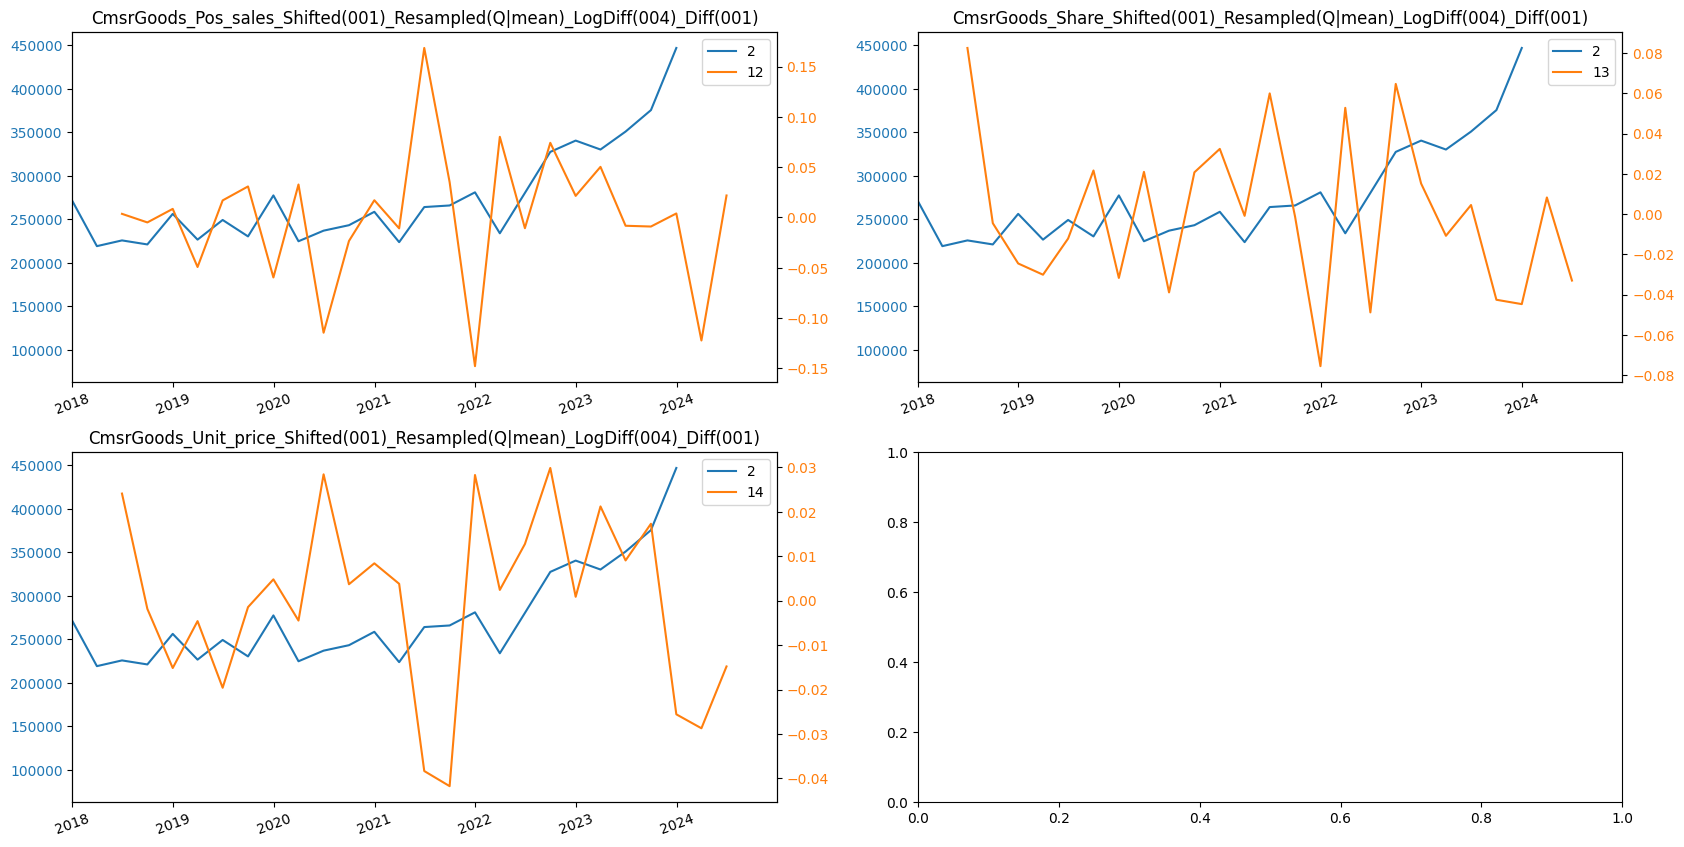

In [29]:
start_date='2018-01-01'

sdh.show_line_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[:4],
    start_date=start_date,
    col_num=2,
    chunk_size=6,
)

ターゲット（ticker）毎にKPI(y)と変数(x)をline描画

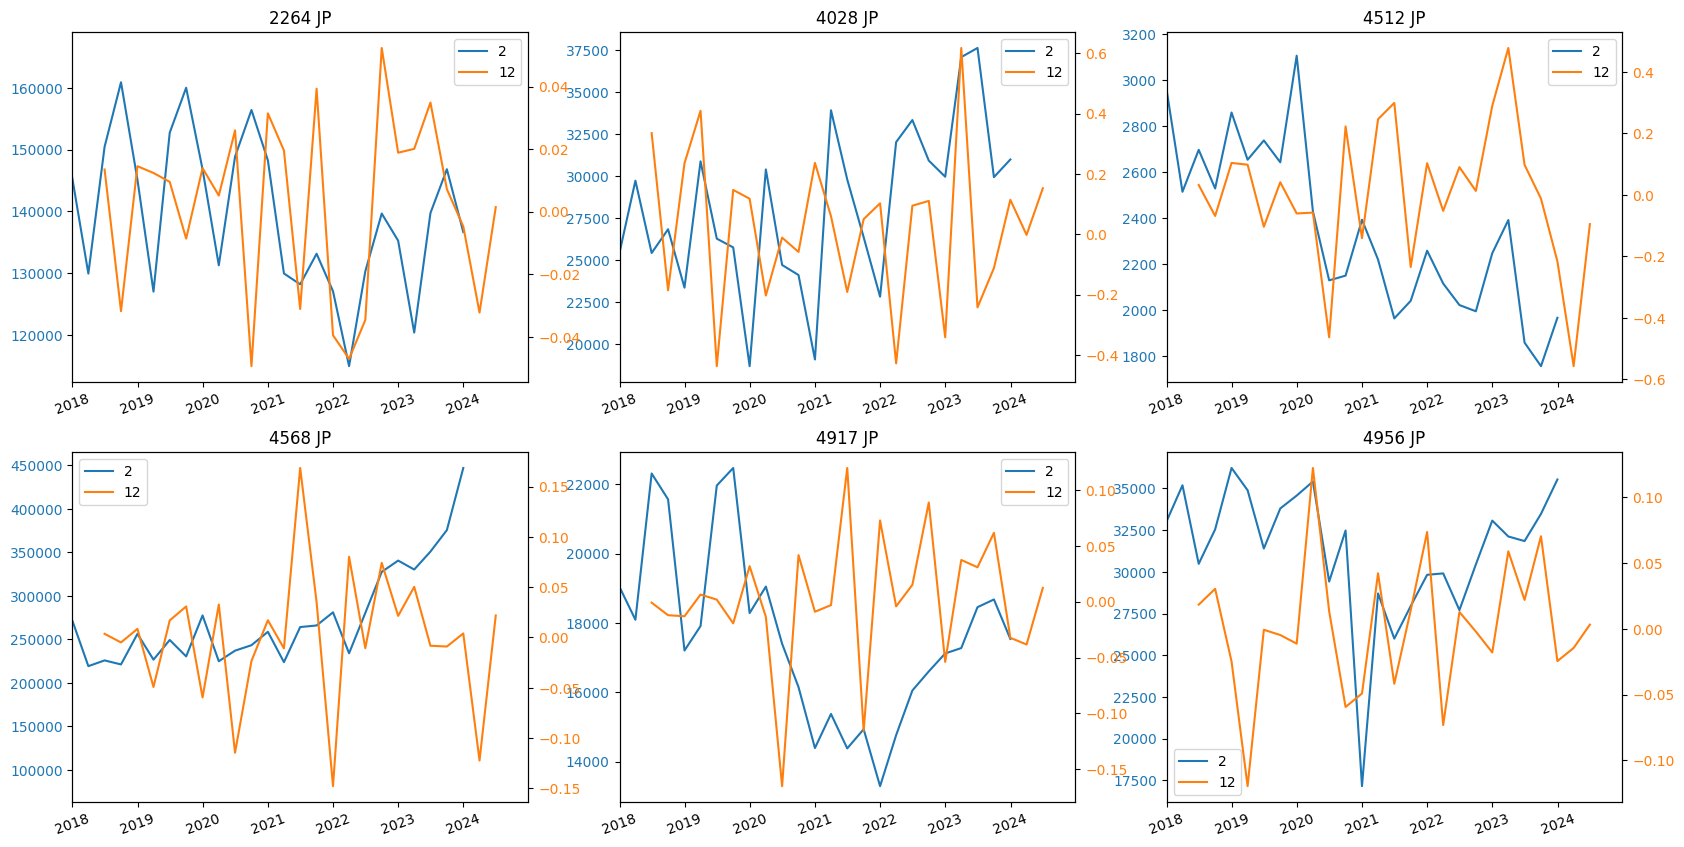

In [30]:
sdh.show_line_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    chunk_size=6)


### Plot Scatter

指定したターゲット(ticker)のKPI(y)と他の変数(X)との散布図を描画

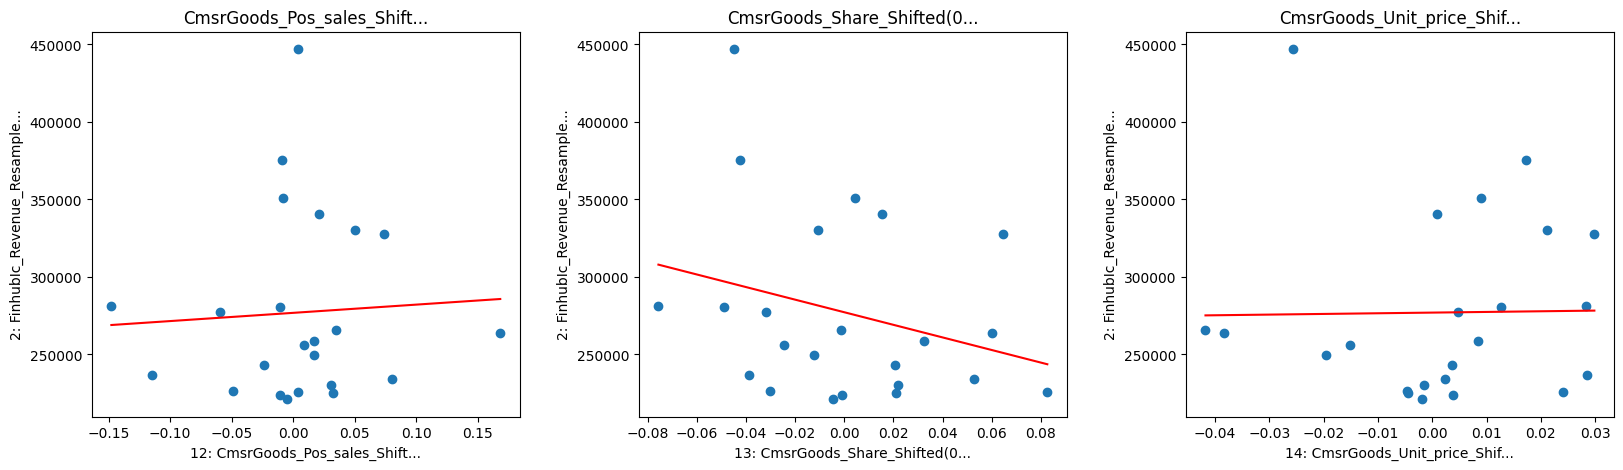

In [31]:
sdh.show_scatter_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[-6:],
    start_date=start_date,
    col_num=3,
    vname_len_limit=25,
)

ターゲット（ticker）毎のKPI(y)と変数(x)の散布図を描画

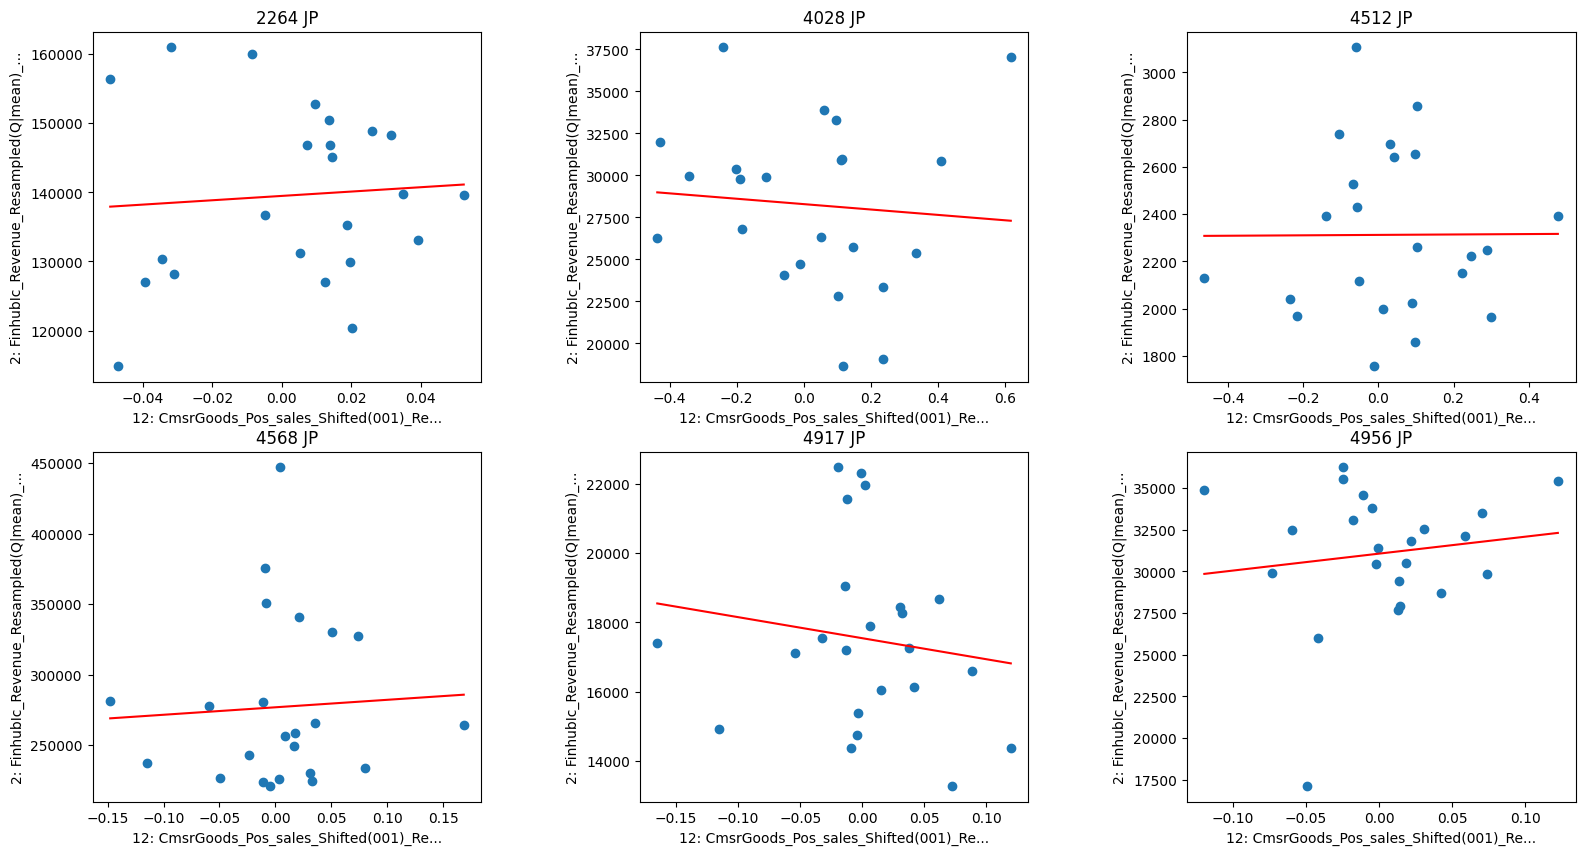

In [32]:
sdh.show_scatter_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    vname_len_limit=35,
)